# Introduction

Import Libraries

In [1]:
import urllib.request
from urllib.request import urlopen

import sys
import spotipy
import spotipy.util as util
import os
import json
import webbrowser
from json.decoder import JSONDecodeError

In [2]:
import pandas as pd
import numpy as np

from scipy import stats

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
from numpy import arange,array,ones
import matplotlib.pyplot as plt

import seaborn as sns
# Set font scale
sns.set(font_scale=1.5)

import itertools

Expand Screen

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Load Data

In [4]:
import json
with open ("C:/Users/anhqu/OneDrive/Desktop/QAs/QA github folder/anhquocduong611_Anjunadeep_playlist_data.json","r") as f:
    playlist_data = json.load(f)

# Bobdy Script

### Calculate Total Duration of the Playlist

In [5]:
def convert_ms(milli):
    seconds=round((milli/1000)%60,2)
    minutes=round((milli/(1000*60))%60,2)
    hours=round((milli/(1000*60*60))%24,2)
    
    hour_read = str(int(hours))+':'+str(int(minutes))
    minute_read = int(hours)*60 + int(minutes)
    return hour_read, minute_read

In [6]:
playlist_duration_ms = 0
for i in range(len(playlist_data)):
    playlist_duration_ms += playlist_data[i]['duration_ms']

    playlist_duration = convert_ms(playlist_duration_ms)

print(playlist_duration)

('3:19', 199)


### Get Summary Statistics about the Playlist

In [7]:
audio_data_point = ['track_name', 'duration_ms', 'popularity', 'danceability', 
                    'energy', 'key', 'mode', 'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo',]

playlist_stats = dict.fromkeys(audio_data_point)

for data_point in audio_data_point:
    audio_stats = []
    for i in range(len(playlist_data)):
        audio_stats.append(playlist_data[i][data_point])
        playlist_stats[data_point] = audio_stats

In [8]:
data_point_plot = ['popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'valence', 'tempo']
data_point_comb = list(itertools.combinations(data_point_plot, r=2))

#### More information about the data points

https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

### Playlist Data Point Distribution

Green line is average line
Red line is median line


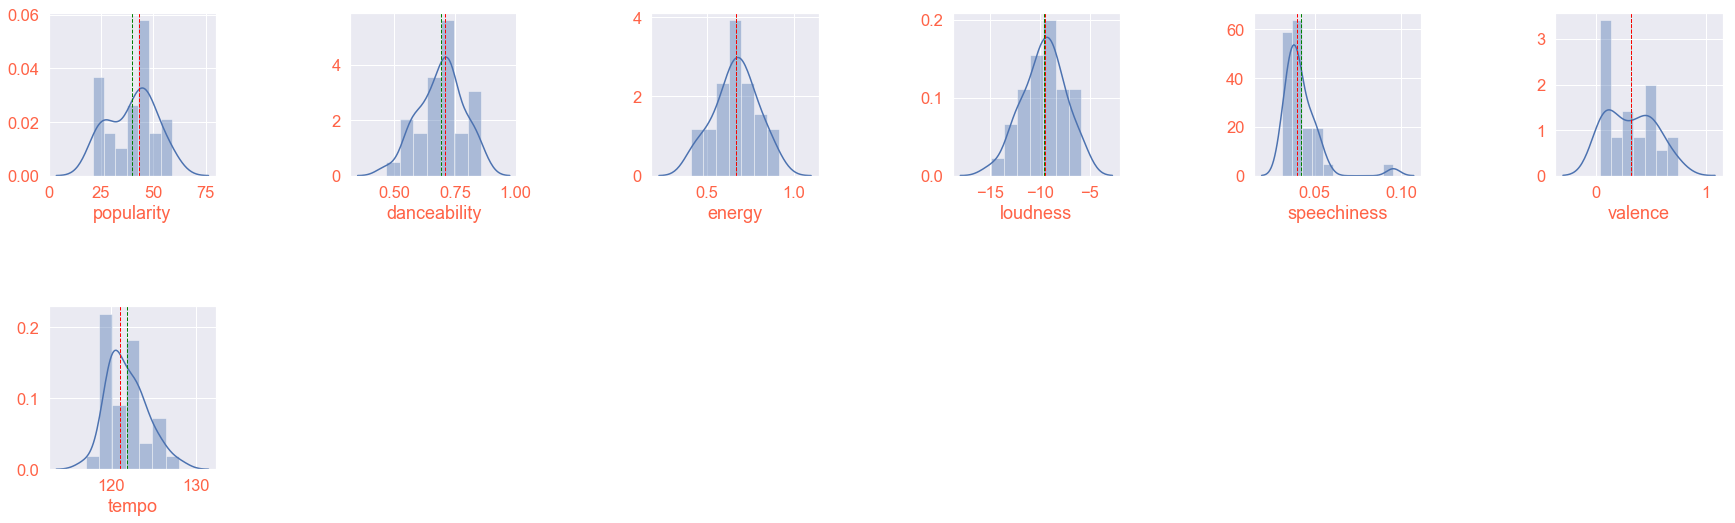

In [9]:
fig = plt.figure(figsize=(30,30))
fig.subplots_adjust(hspace=0.8, wspace=0.8)

print('Green line is average line')
print('Red line is median line')

for i in range(len(data_point_plot)):
    
    ax = fig.add_subplot(6,6,i+1)
    ax = sns.distplot(playlist_stats[data_point_plot[i]], bins='auto')
    
    # Draw average line
    ax.axvline(pd.DataFrame(playlist_stats[data_point_plot[i]]).mean().item(), color='green', linestyle='dashed', linewidth=1)
    # Draw median line
    ax.axvline(pd.DataFrame(playlist_stats[data_point_plot[i]]).median().item(), color='red', linestyle='dashed', linewidth=1)
    
    ax.set_xlabel(data_point_plot[i], color='tomato')
    ax.tick_params(axis='x', colors='tomato')
    ax.tick_params(axis='y', colors='tomato')

Writer's opinion: a homogeneous playlist will have normal distributions among Data Points

### Correlation Between Data Points in the Playlist

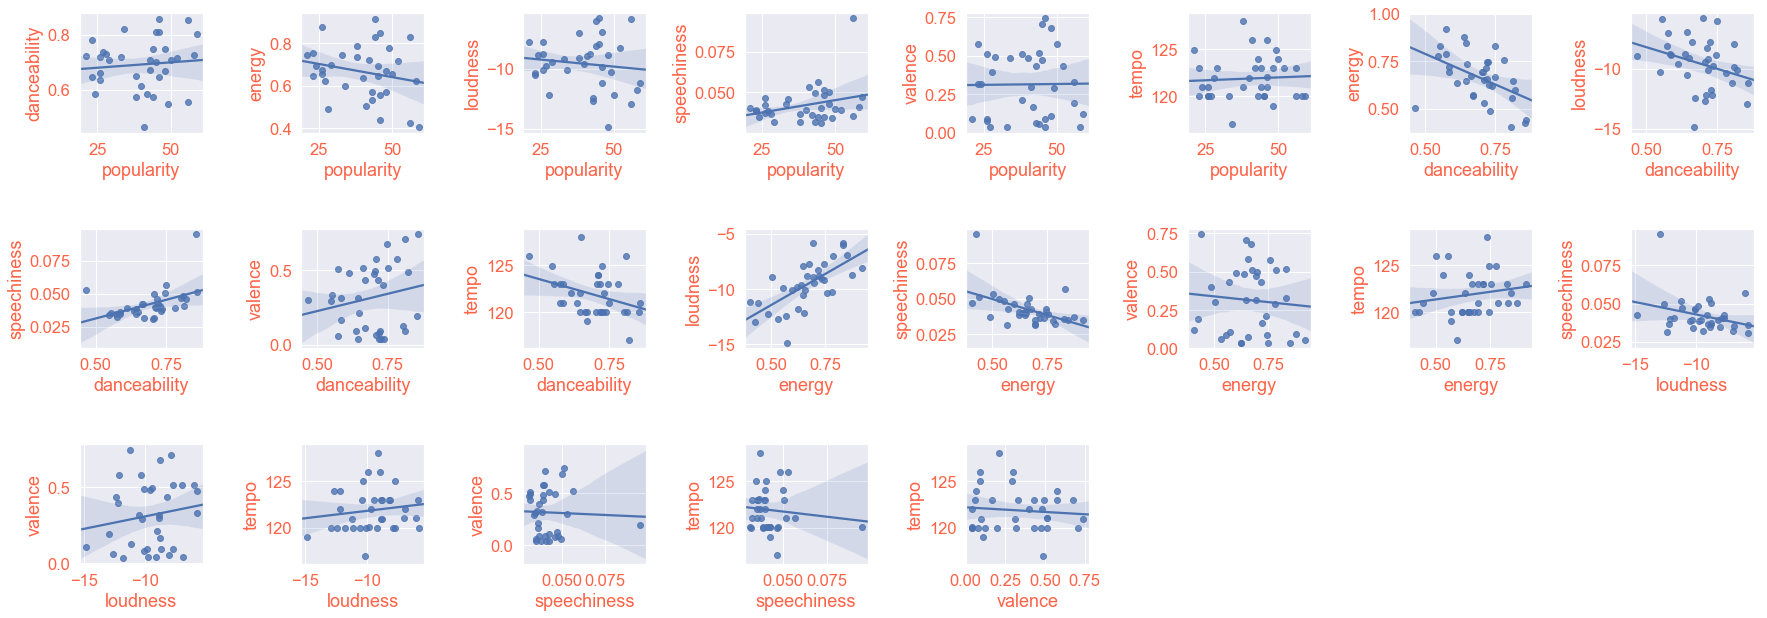

In [10]:
fig = plt.figure(figsize=(30,30))
fig.subplots_adjust(hspace=0.8, wspace=0.8)

for i in range(len(data_point_comb)):
    ax = fig.add_subplot(8,8,i+1)
    ax = sns.regplot(playlist_stats[data_point_comb[i][0]], playlist_stats[data_point_comb[i][1]])
    ax.set_xlabel(data_point_comb[i][0], color='tomato')
    ax.set_ylabel(data_point_comb[i][1], color='tomato')
    ax.tick_params(axis='x', colors='tomato')
    ax.tick_params(axis='y', colors='tomato')

### Plot a Track by Sections

In [11]:
playlist_data[0]['sections'][0].keys()

dict_keys(['start', 'duration', 'confidence', 'loudness', 'tempo', 'tempo_confidence', 'key', 'key_confidence', 'mode', 'mode_confidence', 'time_signature', 'time_signature_confidence'])

###### Convert duration from seconds to minute

In [12]:
for i in range(len(playlist_data)):
    for z in range(len(playlist_data[i]['sections'])):
        playlist_data[i]['sections'][z]['start_minute'] = playlist_data[i]['sections'][z]['start']/60

In [13]:
track_keys = ['start_minute', 'loudness', 'tempo', 'mode']
track_keys_dict = dict.fromkeys(track_keys, 0)
all_tracks_sections = []

track_keys_dict1 = track_keys_dict.copy()

for x in range(len(playlist_data)):
    track_keys_dict1['track_name'] = playlist_data[x]['track_name']
    track_keys_dict1['track_id'] = playlist_data[x]['track_id']
    track_keys_dict1['artist'] = playlist_data[x]['artist']
    track_keys_dict1['album'] = playlist_data[x]['album']
    # For each metric
    for y in track_keys:
        # Reset the list that collects data point 
        track_sections_data = []        
        # For each metric, loop by the number of sections in the track
        for z in range(len(playlist_data[x]['sections'])):
            # Add data point to a list
            track_sections_data.append(playlist_data[x]['sections'][z][y])
            # Add the list to a dict of track data points
            track_keys_dict1[y] = track_sections_data
    # Add the dict to a list of tracks
    all_tracks_sections.append(track_keys_dict1.copy())

###### Function to plot a Track

In [14]:
def plot_track(track_id):
    for i in range(len(playlist_data)):
        if playlist_data[i]['track_id'] == track_id:
            track_index = i
    
    fig = plt.figure(figsize=(5,3))
    fig.subplots_adjust(hspace=0.8, wspace=0.8)
    # Plot title by Track name and Artist
    fig.suptitle(all_tracks_sections[track_index]['track_name'] + ' -- ' + all_tracks_sections[track_index]['artist'], color='tomato', fontsize=20)

    for key, value in enumerate(track_keys[1:3]):
        ax = fig.add_subplot(2,1,key+1)
        ax = sns.lineplot(all_tracks_sections[track_index]['start_minute'], all_tracks_sections[track_index][value])
        ax.set_ylabel(value, color='tomato', fontsize=20)
        ax.tick_params(axis='x', colors='tomato')
        ax.tick_params(axis='y', colors='tomato')
        # Plot average line
        ax.axhline(np.mean(all_tracks_sections[track_index][value]), color='green', linestyle='dashed', linewidth=1)
        # Plot Section breakout line
        for i in range(len(all_tracks_sections[track_index]['start_minute'])):
            ax.axvline(all_tracks_sections[track_index]['start_minute'][i], color='purple', linestyle='dashed', linewidth=1)

    ax.set_xlabel('time', color='tomato')
    # ax.text(1, 1, 'Green line is Average \n Purple line is Section', transform=ax.transAxes, fontsize=14,verticalalignment='bottom', color='tomato')

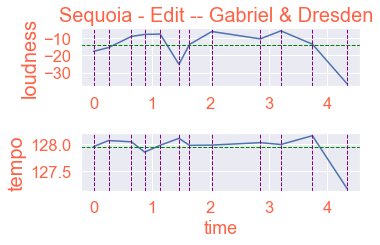

In [15]:
plot_track('7grW4FTwEzN67X01lUiAAx')

# Mix a DJ Set

first is identify intro and outtro song

find track with slow tempo and loudness at the first section. 

find track with highest difference 

##### First is find track with same tempo

to find that we're going to omit the beginning and ending of a track

In [17]:
playlist_data[2]['sections'][0]['duration']

15.47154

In [90]:
for i in range(len(playlist_data)):
    # Duration of 1st Section
    playlist_data[i]['duration_1st_section'] = playlist_data[i]['sections'][0]['duration']
    # Duration of last Section
    playlist_data[i]['duration_last_section'] = playlist_data[i]['sections'][len(playlist_data[i]['sections'])-1]['duration']
    # Tempo of 1st Section
    playlist_data[i]['tempo_1st_section'] = playlist_data[i]['sections'][0]['tempo']
    # Tempo of last Section
    playlist_data[i]['tempo_last_section'] = playlist_data[i]['sections'][len(playlist_data[i]['sections'])-1]['tempo']  
    # Key of 1st Section
    playlist_data[i]['key_1st_section'] = playlist_data[i]['sections'][0]['key']
    # Key of last Section
    playlist_data[i]['key_last_section'] = playlist_data[i]['sections'][len(playlist_data[i]['sections'])-1]['key']   
    # Modality of 1st Section
    playlist_data[i]['modality_1st_section'] = playlist_data[i]['sections'][0]['mode']
    # Modality of last Section
    playlist_data[i]['modality_last_section'] = playlist_data[i]['sections'][len(playlist_data[i]['sections'])-1]['mode']
    # Loudness of 2nd Section
    playlist_data[i]['loudness_1st_section'] = playlist_data[i]['sections'][0]['loudness']
    # Loudness of 2nd last Section
    playlist_data[i]['loudness_last_section'] = playlist_data[i]['sections'][len(playlist_data[i]['sections'])-1]['loudness']

In [91]:
playlist_data[0]

{'track_name': 'Night Blooming Jasmine - Rodriguez Jr. Remix Edit',
 'artist': 'Eli & Fur',
 'album': 'Night Blooming Jasmine (Rodriguez Jr. Remix)',
 'track_id': '4p2huo3cTwy477D3Y9bKWP',
 'popularity': 45,
 'danceability': 0.702,
 'energy': 0.695,
 'key': 5,
 'loudness': -5.809,
 'mode': 0,
 'speechiness': 0.0311,
 'acousticness': 0.000195,
 'instrumentalness': 0.716,
 'liveness': 0.141,
 'valence': 0.474,
 'tempo': 120.007,
 'type': 'audio_features',
 'id': '4p2huo3cTwy477D3Y9bKWP',
 'uri': 'spotify:track:4p2huo3cTwy477D3Y9bKWP',
 'track_href': 'https://api.spotify.com/v1/tracks/4p2huo3cTwy477D3Y9bKWP',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/4p2huo3cTwy477D3Y9bKWP',
 'duration_ms': 316000,
 'time_signature': 4,
 'sections': [{'start': 0.0,
   'duration': 35.0066,
   'confidence': 1.0,
   'loudness': -6.928,
   'tempo': 120.03,
   'tempo_confidence': 0.901,
   'key': 5,
   'key_confidence': 0.02,
   'mode': 0,
   'mode_confidence': 0.41,
   'time_signature': 4,
 

So the goal is the ending of the previous track last second will end at the end of the first section of the next track plus 1 second

In [19]:
playlist_data[3]['sections'][0]['duration'] + 1 == playlist_data[2]['sections'][len(playlist_data[2]['sections'])-1]['duration']

False

In [33]:
previous_track = playlist_data[0]
previous_track_sections = previous_track['sections']
previous_track_last_tempo = previous_track_sections[len(previous_track_sections)-1]['tempo']

In [34]:
next_track = playlist_data[1]
next_track_sections = next_track['sections']
next_track_first_tempo = next_track_sections[len(next_track_sections)-1]['tempo']

In [83]:
def track_playlist_index(track_id):
    for i in range(len(playlist_data)):
        if playlist_data[i]['track_id'] == track_id:
            track_index = i
            return track_index
            break
    print('Not Found')

In [86]:
def tempo_change(previous_track_id, next_track_id):
    
    previous_track_index = track_playlist_index(previous_track_id)
    next_track_index = track_playlist_index(next_track_id)

    previous_track_sections = playlist_data[previous_track_index]['sections']
    previous_track_last_tempo = previous_track_sections[len(previous_track_sections)-1]['tempo']
    
    next_track_sections = playlist_data[next_track_index]['sections']
    next_track_first_tempo = next_track_sections[len(next_track_sections)-1]['tempo']
    
    if 0<= next_track_first_tempo - previous_track_last_tempo <= 5:
        return print('5 tempo up')
    if -5<= next_track_first_tempo - previous_track_last_tempo < 0:
        return print('5 tempo down')
    if next_track_first_tempo - previous_track_last_tempo >5:
        return print('5+ tempo up')
    if next_track_first_tempo - previous_track_last_tempo <-5:
        return print('5+ tempo down')

In [88]:
from scipy import optimize

In [ ]:
def f(x, y):
    p\